<a href="https://colab.research.google.com/github/leonorae/Kaggle-Histopathologic-Cancer-Detection/blob/main/AI_HW5_Kaggle_Cancer_Detection_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Histopathologic Cancer Detection*
## Leonora Goble




In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


!unzip -qq -n /content/drive/MyDrive/histopathologic-cancer-detection.zip -d /content/

umbertogriffo https://www.kaggle.com/competitions/histopathologic-cancer-detection/discussion/82812

semakarevich https://www.kaggle.com/code/sermakarevich/complete-handcrafted-pipeline-in-pytorch-resnet9

1. brief description of the problem, data (e.g. size and dimension, structure etc)

Data preparation code from  notebook

In [11]:
import pandas as pd
import os

labels = pd.read_csv('/content/train_labels.csv')

print(labels.shape[1])
print(labels.shape[0])




2
220025


2. Exploratory data analysis showing a few visualization, histogram, etc, and a plan of analysis. Any data cleaning procedure.


In [30]:
from matplotlib import pyplot as plt

In [12]:
# semakarevich
image_path = '/content/train/'

# limit, shuffle, and split
limit = 1000
labels = labels.sample(n = labels.shape[0])
labels = labels.iloc[:limit]
split = 800
train = labels.iloc[:split]
valid = labels.iloc[:split]

train_labels = train['label'].values.reshape(-1, 1)
valid_labels = valid['label'].values.reshape(-1, 1)

train_images = [os.path.join(image_path, f'{f}.tif') for f in train['id'].values]
valid_images = [os.path.join(image_path, f'{f}.tif') for f in valid['id'].values]



Loading the actual data

In [13]:
# semakarevich
from torch.utils.data import Dataset

class MainDataset(Dataset):
    def __init__(self,
                 x_dataset,
                 y_dataset,
                 x_tfms):
        self.x_dataset = x_dataset
        self.y_dataset = y_dataset
        self.x_tfms = x_tfms

    def __len__(self):
        return self.x_dataset.__len__()

    def __getitem__(self, index):
        x = self.x_dataset[index]
        y = self.y_dataset[index]
        if self.x_tfms is not None:
            x = self.x_tfms(x)
        return x, y

class ImageDataset(Dataset):
    def __init__(self, paths_to_imgs):
        self.paths_to_imgs = paths_to_imgs

    def __len__(self):
        return len(self.paths_to_imgs)

    def __getitem__(self, index: int):
        img = Image.open(self.paths_to_imgs[index])
        return img


class LabelDataset(Dataset):
    def __init__(self, labels):
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index: int):
        return self.labels[index]

train_images_dataset = ImageDataset(train_images)
valid_images_dataset = ImageDataset(valid_images)
train_labels_dataset = LabelDataset(train_labels)
valid_labels_dataset = LabelDataset(valid_labels)

In [14]:
# semakarevich
from PIL import Image
from torchvision import transforms

x_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [15]:
# semakarevich
train_dataset = MainDataset(train_images_dataset, train_labels_dataset, x_tfms)
valid_dataset = MainDataset(valid_images_dataset, valid_labels_dataset, x_tfms)

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset,
                              batch_size=512,
                              shuffle=True,
                              num_workers=0)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=512,
                              shuffle=False,
                              num_workers=0)

3. You model architecture and reasoning why you believe certain architecture would be suitable for this problem


In [17]:
import numpy as np
import keras
import torch
from torch import Tensor
import torch.nn as nn
from functools import partial
from torchvision.models import resnext50_32x4d
from sklearn.metrics import roc_auc_score

use_gpu = True

def to_gpu(tensor):
    return tensor.cuda() if use_gpu else tensor

model = resnext50_32x4d()
in_features = model.fc.in_features
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc = nn.Linear(in_features, 1)
model = to_gpu(model)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [18]:
from torch.optim import Adam

lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)

In [19]:
loss = nn.BCEWithLogitsLoss()

In [20]:
from torch.autograd import Variable

def train_one_epoch(model,
                    train_dataloader,
                    valid_dataloader,
                    loss,
                    optimizer,
                    loss_writer_train,
                    loss_writer_valid,
                    do_step_trigger,
                    valid_loss_trigger,
                    train_loss_trigger,
                    ):
    model.train()
    y_true_train, y_hat_train = [], []
    for iteration, (x, y) in enumerate(train_dataloader):
        x = Variable(T(x), requires_grad=True)
        y = Variable(T(y), requires_grad=True)
        output = model(x)
        y_true_train.append(to_numpy(y))
        y_hat_train.append(to_numpy(output))
        loss_values = loss(output, y)
        loss_values.backward()
        if do_step_trigger(iteration):
            optimizer.step()
            optimizer.zero_grad()
        if train_loss_trigger(iteration):
            auc_writer(y_true_train, y_hat_train, iteration)
            y_true_train, y_hat_train = [], []
        if valid_loss_trigger(iteration):
            y_true, y_hat = predict(model, valid_dataloader)
            auc_writer(y_true, y_hat, iteration)
    return model



In [21]:
def predict(model, dataloader):
    model.eval()
    y_true, y_hat = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = Variable(T(x))
            y = Variable(T(y))
            output = model(x)
            y_true.append(to_numpy(y))
            y_hat.append(to_numpy(output))
    return y_true, y_hat

In [22]:
def iteration_trigger(iteration, every_x_iterations):
    if every_x_iterations == 1:
        return True
    elif iteration > 0 and iteration % every_x_iterations == 0:
        return True
    else:
        return False


def init_triggers(step=1, valid=10, train=10):
    do_step_trigger = partial(iteration_trigger, every_x_iterations=step)
    valid_loss_trigger = partial(iteration_trigger, every_x_iterations=valid)
    train_loss_trigger = partial(iteration_trigger, every_x_iterations=train)
    return do_step_trigger, valid_loss_trigger, train_loss_trigger

In [23]:
def auc_writer(y_true, y_hat, iteration):
    try:
        auc = roc_auc_score(np.vstack(y_true), np.vstack(y_hat))
    except:
        auc = -1

In [24]:
def T(tensor):
    if not torch.is_tensor(tensor):
        tensor = torch.FloatTensor(tensor)
    else:
        tensor = tensor.type(torch.FloatTensor)
    if use_gpu:
        tensor = to_gpu(tensor)
    return tensor


def to_numpy(tensor):
    if type(tensor) == np.array or type(tensor) == np.ndarray:
        return np.array(tensor)
    elif type(tensor) == Image.Image:
        return np.array(tensor)
    elif type(tensor) == Tensor:
        return tensor.cpu().detach().numpy()
    else:
        raise ValueError("type")

In [25]:
loss_writer_train = auc_writer
loss_writer_valid = auc_writer

# backpropagate - every iter
# calculate AUC on valid - every 20 iters
# AUC on train - every 10 iters
do_step_trigger, valid_loss_trigger, train_loss_trigger = init_triggers(1, 20, 10)

In [26]:
model = train_one_epoch(
    model,
    train_dataloader,
    valid_dataloader,
    loss,
    optimizer,
    loss_writer_train,
    loss_writer_valid,
    do_step_trigger,
    valid_loss_trigger,
    train_loss_trigger,
)

In [27]:
y_true, y_hat = predict(model, valid_dataloader)

In [28]:
predictions = pd.DataFrame(
    list(
        zip(
            valid_labels.reshape(-1),
            np.vstack(y_hat).reshape(-1),
            valid_images
        )
    ),
     columns=['true', 'pred', 'files'])
predictions.head(3)

,true,pred,files
0,0,0.318557,/content/train/c65a07f9561ee7f2d51f9085e77ced3...
1,1,0.315108,/content/train/fdc7090d6c8876f0679861225ea49ea...
2,0,0.322957,/content/train/2c90d70fb0f695ea4347f42df1d0681...


4. results (tables, figures etc) and analysis (reasoning of why or why not something worked well, also troubleshooting and hyperparameter optimization procedure summary)


In [35]:
max_charts = 60
def implot(files, w=2, h=2, cols=12):
    rows = len(files) // cols + 1
    images = [Image.open(f) for f in files]
    plt.figure(figsize = (cols * w, rows * h))
    plt.tight_layout()
    for chart, img in enumerate(images, 1):
        ax = plt.subplot(rows, cols, chart)
        ax.imshow(np.array(img))
        ax.axis('off')



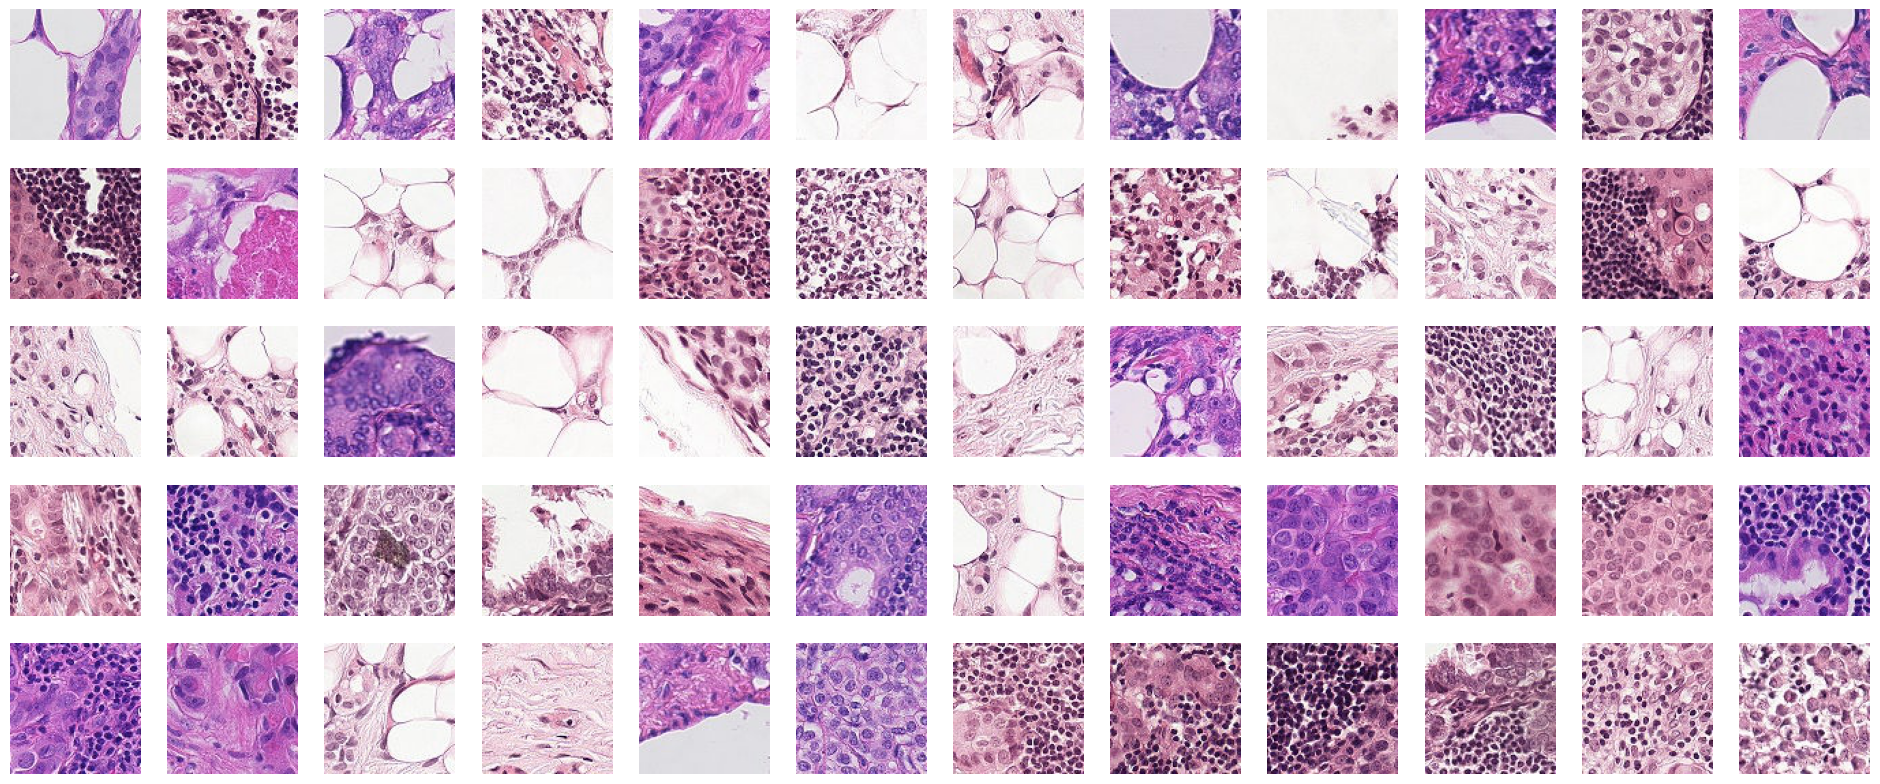

In [36]:
files = predictions[predictions['true']==1].sort_values('pred')['files'].values[:max_charts]
implot(files)

5. your conclusion.
